In [39]:
%matplotlib inline
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from time import strptime

In [2]:
#Read CSV files into DataFrames.
sales_df = pd.read_csv('train.csv', parse_dates = [2])
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv', parse_dates = [3])

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>To Classify wheather a given day will be high sales or low sales, we need to associate the store data with daily sales data. So we need to join store and train dataframes.</li>
<li>Also we can split the date field of daily sales into day, month and year as these are most likely more correlated to the amount of sales in a store.</li>
<li>Also we can drop 'Customers' field as we wont have it in the test data.</li>
</ul>
</article>

In [6]:
#Join the sales and store DataFrames into one.
train_df = pd.merge(sales_df, store_df, on='Store')
#Description of train DataFrame.
print(train_df.describe())
#Datatypes and fields of train DataFrame.
print(train_df.info())
#Fields Containing Missing Values in train DataFrame.
print(train_df.isnull().any())

              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  CompetitionDistance  \
count  1.017209e+06   1.017209e+06         1.014567e+06   
mean   3.815145e-01   1.786467e-01         5.430086e+03   
std    4.857586e-01   3.830564e-01         7.715324e+03   
min    0.000000e+00   0.000000e+00         2.000000e

In [7]:
#Droping Customers
train_df.drop('Customers', axis = 1, inplace = True)
#Splitting Date field into Current Year, Month and Day.
train_df['CurYear'] = train_df.Date.dt.year
train_df['CurMonth'] = train_df.Date.dt.month
train_df['CurDay'] = train_df.Date.dt.day

<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>For Classification we need some label field indicator, In our case we are trying to classify future performance
of these stores.</li>
<li>We can create our 'Performance' label from Sales field of train DataFrame.</li>
<li>Also there is no sale on days when the shops are closed. So data on days when shops are closed are removed.</li> 
</ul>
</article>

In [8]:
#Removing train DataFrame rows when Open field is 0
train_df = train_df[train_df['Open'] == 1]
#Remove the now redundant Open field
train_df.drop('Open', axis = 1, inplace = True)

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64


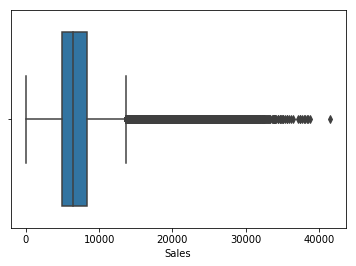

In [9]:
#Sales Exploration to add a new field Performance.
print(train_df['Sales'].describe())
#Plotting the sales field to see its behaviour
ax = sns.boxplot(x = 'Sales', data = train_df)

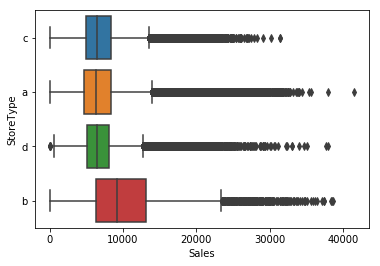

In [10]:
#Plotting the Sales field with StoreType.
ax = sns.boxplot(x = 'Sales', y = 'StoreType', data = train_df)

<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>Instead of using mean sales or median sales to create our label, we can use mean of each StoreType for partitioning sales data as High Performance and Low Performance.</li>
<li>If the daily sales of a store is more than or equal to the average sales for that StoreType then we can classify them as high perfoming and otherwise low performing.</li>
</ul>
</article>

In [11]:
#Explore StoreTypes
store_types = train_df['StoreType'].unique()
print(store_types)
#Create a DataFrame holding means for each StoreTypes.
store_means_df = pd.DataFrame([(train_df[train_df['StoreType'] == s_type].Sales.mean() for s_type in store_types)], 
                          columns = store_types)
print(store_means_df.head())
#Create a Series containing our new field Performance.
performance_series = pd.Series([1 if(row.Sales >= (store_means_df[row.StoreType]).values[0]) else 0 for index, 
                                row in train_df.iterrows()])
#Add performance Series to our train DataFrame.
train_df = train_df.assign(Performance = performance_series.values)
print(train_df.info())
train_df.head()

['c' 'a' 'd' 'b']
             c            a            d             b
0  6932.512755  6925.167661  6822.141881  10231.407505
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017207
Data columns (total 20 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null datetime64[ns]
Sales                        844392 non-null int64
Promo                        844392 non-null int64
StateHoliday                 844392 non-null object
SchoolHoliday                844392 non-null int64
StoreType                    844392 non-null object
Assortment                   844392 non-null object
CompetitionDistance          842206 non-null float64
CompetitionOpenSinceMonth    575773 non-null float64
CompetitionOpenSinceYear     575773 non-null float64
Promo2                       844392 non-null int64
Promo2SinceWeek              421085 non-null float64
Promo2SinceYear           

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CurYear,CurMonth,CurDay,Performance
0,1,5,2015-07-31,5263,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,0
1,1,4,2015-07-30,5020,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,30,0
2,1,3,2015-07-29,4782,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,29,0
3,1,2,2015-07-28,5011,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,28,0
4,1,1,2015-07-27,6102,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,27,0


In [12]:
#Exploring sales data having sale = 0.
print("No of rows having zero sales : " + str(len(train_df[train_df['Sales'] == 0])))

No of rows having zero sales : 54


<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>There are still sales data which have zero sales. These are not removed as they represent information showing correlation between Current date, Holidays, ShopType and Sales.</li>
</ul>
</article>

In [13]:
#Explore the stores having promo2 offer.
promo2_store_df = store_df[store_df['Promo2'] == 1]
promo2_store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>Since Promo2SinceWeek and Promo2SinceYear represent time elapsed since the store started giving promo2, we can combine them into a Promo2Time.</li>
<li>We can find the difference between current Date field and promo2 start date to indicate wheather promo2 was active during the sales day. This can be indicated by another field Promo2Active.</li>
</ul>
</article>

In [14]:
#Calculate wheather currently the store is having Promo2 or not.

def calculate_promo2(months_string, promo2_week, promo2_year, cur_date):
    abbr_months = months_string.replace('Sept', 'Sep').split(",")
    numeric_months = [strptime(mnth, '%b').tm_mon for mnth in abbr_months]
    cur_year = cur_date.year
    cur_month = cur_date.month
    cur_week = cur_date.weekofyear
    if((cur_month in numeric_months) and (cur_year > promo2_year or 
                                          (cur_year == promo2_year and cur_week >= promo2_week))):
        return 1
    else:
        return 0

promo_interval_series = [calculate_promo2(row.PromoInterval, row.Promo2SinceWeek, row.Promo2SinceYear, 
                                                   row.Date) if row.Promo2 == 1 else 0 for index, 
                         row in train_df.iterrows()]

In [15]:
#Create a Series out of the new Promo2Active field.
promo_interval_series = pd.Series(promo_interval_series, name='Promo2Active')
#Droping Promo2 and PromoInterval fields which are now unneccessary.
train_df.drop(['Promo2', 'PromoInterval'], axis = 1, inplace = True)
#Adding Promo2Active field to train DataFrame.
train_df = train_df.assign(Promo2Active = promo_interval_series.values)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017207
Data columns (total 19 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null datetime64[ns]
Sales                        844392 non-null int64
Promo                        844392 non-null int64
StateHoliday                 844392 non-null object
SchoolHoliday                844392 non-null int64
StoreType                    844392 non-null object
Assortment                   844392 non-null object
CompetitionDistance          842206 non-null float64
CompetitionOpenSinceMonth    575773 non-null float64
CompetitionOpenSinceYear     575773 non-null float64
Promo2SinceWeek              421085 non-null float64
Promo2SinceYear              421085 non-null float64
CurYear                      844392 non-null int64
CurMonth                     844392 non-null int64
CurDay                       844392 non-null int64

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,CurYear,CurMonth,CurDay,Performance,Promo2Active
0,1,5,2015-07-31,5263,1,0,1,c,a,1270.0,9.0,2008.0,NaN,NaN,2015,7,31,0,0
1,1,4,2015-07-30,5020,1,0,1,c,a,1270.0,9.0,2008.0,NaN,NaN,2015,7,30,0,0
2,1,3,2015-07-29,4782,1,0,1,c,a,1270.0,9.0,2008.0,NaN,NaN,2015,7,29,0,0
3,1,2,2015-07-28,5011,1,0,1,c,a,1270.0,9.0,2008.0,NaN,NaN,2015,7,28,0,0
4,1,1,2015-07-27,6102,1,0,1,c,a,1270.0,9.0,2008.0,NaN,NaN,2015,7,27,0,0


In [16]:
#Explore the max and min values of Promo2SinceWeek field for calculating the new Promo2Time field.
#Merging Promo2SinceWeek and Promo2SinceYears
def calculate_promo2_time(promo2_week, promo2_year, cur_date):
    cur_year = cur_date.year
    cur_week = cur_date.weekofyear
    promo2_time = 0
    if(cur_year > promo2_year):
        promo2_time = (52 - promo2_week) + (cur_year - promo2_year - 1)*52 + cur_week
    elif(cur_year == promo2_year):
        promo2_time = cur_week - promo2_week
    else:
        #For Check purposes.
        promo2_time = -10
    return promo2_time

promo2_time_series = [calculate_promo2_time(row.Promo2SinceWeek, row.Promo2SinceYear, row.Date) 
                     if row.Promo2Active == 1 else -1 for index, row in train_df.iterrows()]

In [17]:
promo2_time_series = pd.Series(promo2_time_series, name = 'Promo2Time')
#Checking if calculated values are correct or not.
print(len(promo2_time_series[promo2_time_series < -1]))
#Drop Promo2SinceWeek and Promo2SinceYear fields.
train_df.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis = 1, inplace = True)
#Add Promo2Time field to train DataFrame.
train_df = train_df.assign(Promo2Time = promo2_time_series.values)
print(train_df.info())
train_df.head()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017207
Data columns (total 18 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null datetime64[ns]
Sales                        844392 non-null int64
Promo                        844392 non-null int64
StateHoliday                 844392 non-null object
SchoolHoliday                844392 non-null int64
StoreType                    844392 non-null object
Assortment                   844392 non-null object
CompetitionDistance          842206 non-null float64
CompetitionOpenSinceMonth    575773 non-null float64
CompetitionOpenSinceYear     575773 non-null float64
CurYear                      844392 non-null int64
CurMonth                     844392 non-null int64
CurDay                       844392 non-null int64
Performance                  844392 non-null int64
Promo2Active                 844392 non-null int64
P

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CurYear,CurMonth,CurDay,Performance,Promo2Active,Promo2Time
0,1,5,2015-07-31,5263,1,0,1,c,a,1270.0,9.0,2008.0,2015,7,31,0,0,-1.0
1,1,4,2015-07-30,5020,1,0,1,c,a,1270.0,9.0,2008.0,2015,7,30,0,0,-1.0
2,1,3,2015-07-29,4782,1,0,1,c,a,1270.0,9.0,2008.0,2015,7,29,0,0,-1.0
3,1,2,2015-07-28,5011,1,0,1,c,a,1270.0,9.0,2008.0,2015,7,28,0,0,-1.0
4,1,1,2015-07-27,6102,1,0,1,c,a,1270.0,9.0,2008.0,2015,7,27,0,0,-1.0


In [18]:
#Explore the stores having maximum CompetitionOpenSince timestamp.
max_competition_store_df = store_df.sort_values(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], 
                                               ascending = [False, False]).head(1)
max_competition_store_df.loc[:, ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']]

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
687,8.0,2015.0


In [19]:
#Explore the values of CompetitionDistance and CompetitionOpenSince fields.
print(train_df.isnull().any())
print(train_df['CompetitionDistance'].max())
print(train_df['CompetitionDistance'].min())
print(len(train_df[train_df['CompetitionDistance'].isnull()]))
print(len(train_df[train_df['CompetitionOpenSinceMonth'].isnull()]))
print(len(train_df[train_df['CompetitionOpenSinceYear'].isnull()]))

Store                        False
DayOfWeek                    False
Date                         False
Sales                        False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
CurYear                      False
CurMonth                     False
CurDay                       False
Performance                  False
Promo2Active                 False
Promo2Time                   False
dtype: bool
75860.0
20.0
2186
268619
268619


<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>CompetitionOpenSince fields can be used to infer wheather there was competition on the day of the sales.</li>
<li>A large no of rows doesn't have CompetitionOpenSince field. Since Wheather there was Competition or not is an important feature, we can drop the rows that doesn't have these fields.</li>
<li>Also CompetitionDistance is missing for some rows, these are relatively small and can inferred as no competition or large competition distance. In both case these values are filled by a large distance value of 10000.</li>
</ul>
</article>

In [20]:
#Filling the missing CompetitionDistance with large values.
train_df['CompetitionDistance'].fillna(10000, inplace = True)
#Dropping the rows not having a CompetitionOpenSince field.
train_df.dropna(inplace = True)

In [21]:
#Calculating wheather competition was active on each sales day and merging it with competition distance.
def calculate_competition(comp_dist, comp_year, comp_month, cur_date):
    cur_year = cur_date.year
    cur_month = cur_date.month
    if(cur_year > comp_year or (cur_year == comp_year and cur_month >= comp_month)):
        return comp_dist
    else:
        return 10000

competition_active_series = [calculate_competition(row.CompetitionDistance, row.CompetitionOpenSinceYear,
                                                   row.CompetitionOpenSinceMonth, row.Date) for index, row in 
                             train_df.iterrows()]

In [22]:
competition_active_series = pd.Series(competition_active_series, name = 'CompetitonDistance')
#Dropping CompetitionDistance and CompetitionOpenSince fields.
train_df.drop(['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1, 
              inplace = True)
#Adding our new CompetitionDistance field to train DataFrame.
train_df = train_df.assign(CompetitionDistance = competition_active_series.values)
print(train_df.info())
print(train_df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575773 entries, 0 to 1014381
Data columns (total 16 columns):
Store                  575773 non-null int64
DayOfWeek              575773 non-null int64
Date                   575773 non-null datetime64[ns]
Sales                  575773 non-null int64
Promo                  575773 non-null int64
StateHoliday           575773 non-null object
SchoolHoliday          575773 non-null int64
StoreType              575773 non-null object
Assortment             575773 non-null object
CurYear                575773 non-null int64
CurMonth               575773 non-null int64
CurDay                 575773 non-null int64
Performance            575773 non-null int64
Promo2Active           575773 non-null int64
Promo2Time             575773 non-null float64
CompetitionDistance    575773 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(10), object(3)
memory usage: 74.7+ MB
None
Store                  False
DayOfWeek              False
Date  

In [23]:
#Dropping Date and Sales fields.
train_df.drop(['Date', 'Sales'], axis = 1, inplace = True)

In [24]:
print(train_df.info())
print(train_df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575773 entries, 0 to 1014381
Data columns (total 14 columns):
Store                  575773 non-null int64
DayOfWeek              575773 non-null int64
Promo                  575773 non-null int64
StateHoliday           575773 non-null object
SchoolHoliday          575773 non-null int64
StoreType              575773 non-null object
Assortment             575773 non-null object
CurYear                575773 non-null int64
CurMonth               575773 non-null int64
CurDay                 575773 non-null int64
Performance            575773 non-null int64
Promo2Active           575773 non-null int64
Promo2Time             575773 non-null float64
CompetitionDistance    575773 non-null float64
dtypes: float64(2), int64(9), object(3)
memory usage: 65.9+ MB
None
Store                  False
DayOfWeek              False
Promo                  False
StateHoliday           False
SchoolHoliday          False
StoreType              False
Assortmen

<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>Some of the fields have a datatype of 'Object'. This cannot be used for classification and should be converted to numeric types</li>
<li>We use sklearn's Label Encoder for this purpose </li>
</ul>
</article>

In [25]:
#Convert Object types in train DataFrame to Numeric
print(train_df['StateHoliday'].unique())
enc = LabelEncoder()
train_df['StateHoliday'] = enc.fit_transform(train_df['StateHoliday'].astype(str))
print(train_df['StateHoliday'].unique())

print(train_df['StoreType'].unique())
enc = LabelEncoder()
train_df['StoreType'] = enc.fit_transform(train_df['StoreType'].astype(str))
print(train_df['StoreType'].unique())

print(train_df['Assortment'].unique())
enc = LabelEncoder()
train_df['Assortment'] = enc.fit_transform(train_df['Assortment'].astype(str))
print(train_df['Assortment'].unique())

['0' 0 'a' 'b' 'c']
[0 1 2 3]
['c' 'a' 'd' 'b']
[2 0 3 1]
['a' 'c' 'b']
[0 2 1]


In [26]:
#Checking if the final features contain any constants.
print(np.sum(train_df.var() == 0))

0


In [27]:
#Split Training Data into test and train
train, test = train_test_split(train_df, test_size=0.2)

In [28]:
#Split the DataFrames into train/test Features and train/test Labels for Classification.
train_features = train.drop('Performance', axis = 1)
train_labels = train['Performance']
print(train_features.info())
print(train_labels.head())
test_features = test.drop('Performance', axis = 1)
test_labels = test['Performance']
print(test_features.info())
print(test_labels.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460618 entries, 747770 to 28515
Data columns (total 13 columns):
Store                  460618 non-null int64
DayOfWeek              460618 non-null int64
Promo                  460618 non-null int64
StateHoliday           460618 non-null int64
SchoolHoliday          460618 non-null int64
StoreType              460618 non-null int64
Assortment             460618 non-null int64
CurYear                460618 non-null int64
CurMonth               460618 non-null int64
CurDay                 460618 non-null int64
Promo2Active           460618 non-null int64
Promo2Time             460618 non-null float64
CompetitionDistance    460618 non-null float64
dtypes: float64(2), int64(11)
memory usage: 49.2 MB
None
747770    0
192145    0
822480    1
589623    0
462574    1
Name: Performance, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 115155 entries, 481789 to 153939
Data columns (total 13 columns):
Store                  115155 n

In [29]:
#Create a RandomForestClassifier and train it.
rand_clf = RandomForestClassifier(n_jobs = 2, random_state = 0)
rand_clf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [30]:
#Score of the RandomForestClassifier
rand_score = rand_clf.score(test_features, test_labels)
print(rand_score)

0.851270027354


<article>
<h3  style="text-decoration: underline;">Observation</h3>
<ul>
<li>RandomForestClassifier recorded an accuracy of 84.45%</li>
</ul>
</article>

In [31]:
#Calculating the Confusion Matrix.
predicted_labels = rand_clf.predict(test_features)
test_labels_series = test_labels.rename("Actual")
predicted_labels_series = pd.Series(predicted_labels, name = "Predicted")
cnf_matrix = pd.crosstab(test_labels_series, predicted_labels_series, margins = True)
print(cnf_matrix)

Predicted   0.0   1.0    All
Actual                      
0.0        5409  3275   8684
1.0        3678  2288   5966
All        9087  5563  14650


In [33]:
#Calculating the normalized Confusion Matrix.
cnf_matrix = pd.crosstab(test_labels_series, predicted_labels_series)
cnf_matrix_normalized = cnf_matrix / cnf_matrix.sum(axis = 1)
print(cnf_matrix_normalized)

Predicted       0.0       1.0
Actual                       
0.0        0.622870  0.548944
1.0        0.423538  0.383507


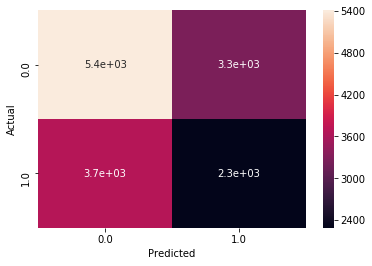

In [34]:
#Plotting Confusion Matrices.
sns.heatmap(cnf_matrix, annot = True)

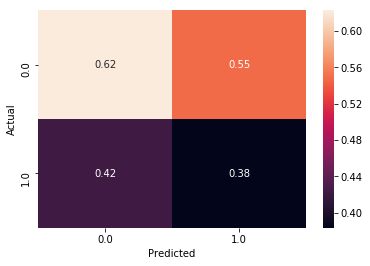

In [35]:
sns.heatmap(cnf_matrix_normalized, annot = True)

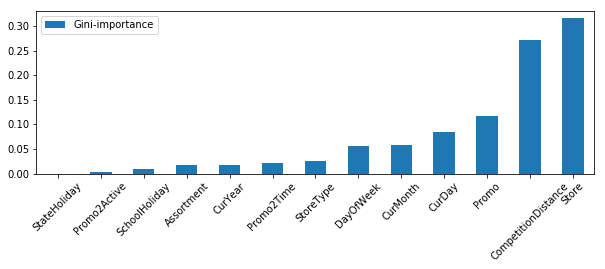

In [36]:
#Calculating Feature Importance.
feature_imp_dict = {}
for feature, importance in zip(train_features.columns, rand_clf.feature_importances_):
    feature_imp_dict[feature] = importance
feature_imp_df = pd.DataFrame.from_dict(feature_imp_dict, orient='index').rename(columns={0: 'Gini-importance'})
feature_imp_df.sort_values(by='Gini-importance').plot(kind='bar', rot=45, figsize = (10,3))

In [40]:
#Splitting the entire data in 45:55 ratio(training: 260000, testing: 310000)
train, test = train_test_split(train_df, test_size=0.55)
print(len(train))
print(len(test))

259097
316676


In [41]:
#Split the DataFrames into train/test Features and train/test Labels for Classification.
train_features = train.drop('Performance', axis = 1)
train_labels = train['Performance']
print(train_features.info())
print(train_labels.head())
test_features = test.drop('Performance', axis = 1)
test_labels = test['Performance']
print(test_features.info())
print(test_labels.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259097 entries, 305481 to 676022
Data columns (total 13 columns):
Store                  259097 non-null int64
DayOfWeek              259097 non-null int64
Promo                  259097 non-null int64
StateHoliday           259097 non-null int64
SchoolHoliday          259097 non-null int64
StoreType              259097 non-null int64
Assortment             259097 non-null int64
CurYear                259097 non-null int64
CurMonth               259097 non-null int64
CurDay                 259097 non-null int64
Promo2Active           259097 non-null int64
Promo2Time             259097 non-null float64
CompetitionDistance    259097 non-null float64
dtypes: float64(2), int64(11)
memory usage: 27.7 MB
None
305481    1
336973    0
468596    0
385922    1
807046    1
Name: Performance, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 316676 entries, 940634 to 87314
Data columns (total 13 columns):
Store                  316676 n

In [42]:
#Create the RandomForestClassifier and train.
rand_clf = RandomForestClassifier(n_jobs = 2, random_state = 0)
rand_clf.fit(train_features, train_labels)
#Score of the RandomForestClassifier
rand_score2 = rand_clf.score(test_features, test_labels)
print(rand_score2)

0.830947087875


In [43]:
#Random Forest with increased no of trees.
rand_clf = RandomForestClassifier(n_estimators = 20, n_jobs = 2, random_state = 0)
rand_clf.fit(train_features, train_labels)
#Score of the RandomForestClassifier
rand_score3 = rand_clf.score(test_features, test_labels)
print(rand_score3)

0.848248683197


In [44]:
#Do a Simple 5-Fold Cross Validation without Shuffle.
rand_clf = RandomForestClassifier(n_estimators = 20, n_jobs = 2, random_state = 0)
data_features = train_df.drop('Performance', axis = 1)
data_labels = train_df['Performance']
cv_scores = cross_val_score(rand_clf, data_features, data_labels, cv = 5)
print(cv_scores)
mean_cv_score = cv_scores.mean()
cv_scores_std = cv_scores.std()
print("Mean Score: %f, 95%% Confidence Interval: [%f,%f]" %(mean_cv_score, mean_cv_score - (cv_scores_std * 2),
                                                          mean_cv_score + (cv_scores_std * 2)))

[ 0.5830142   0.64391472  0.63503105  0.65760634  0.61745141]
Mean Score: 0.627404, 95% Confidence Interval: [0.575926,0.678881]


In [45]:
#Do a Simple 10-Fold Cross Validation.
rand_clf = RandomForestClassifier(n_estimators = 20, n_jobs = 2, random_state = 0)
cv_scores = cross_val_score(rand_clf, data_features, data_labels, cv = 10)
print(cv_scores)
mean_cv_score = cv_scores.mean()
cv_scores_std = cv_scores.std()
print("Mean Score: %f, 95%% Confidence Interval: [%f,%f]" %(mean_cv_score, mean_cv_score - (cv_scores_std * 2),
                                                          mean_cv_score + (cv_scores_std * 2)))

[ 0.64609747  0.63569419  0.64055716  0.61653091  0.62526703  0.68537784
  0.67863904  0.67170919  0.64944335  0.57434392]
Mean Score: 0.642366, 95% Confidence Interval: [0.579995,0.704737]


In [46]:
#Do a Shuffled 5-Fold Cross Validation.
rand_clf = RandomForestClassifier(n_estimators = 20, n_jobs = 2, random_state = 0)
cv = ShuffleSplit(n_splits = 5, test_size = 0.5, random_state = 0)
cv_scores = cross_val_score(rand_clf, data_features, data_labels, cv = cv)
print(cv_scores)
mean_cv_score = cv_scores.mean()
cv_scores_std = cv_scores.std()
print("Mean Score: %f, 95%% Confidence Interval: [%f,%f]" %(mean_cv_score, mean_cv_score - (cv_scores_std * 2),
                                                          mean_cv_score + (cv_scores_std * 2)))

[ 0.84291753  0.84495305  0.8501148   0.85100404  0.84856558]
Mean Score: 0.847511, 95% Confidence Interval: [0.841331,0.853691]


In [48]:
#Do a Shuffled 10-Fold Cross Validation.
rand_clf = RandomForestClassifier(n_estimators = 20, n_jobs = 2, random_state = 0)
cv = ShuffleSplit(n_splits = 10, test_size = 0.5, random_state = 0)
cv_scores = cross_val_score(rand_clf, data_features, data_labels, cv = cv)
print(cv_scores)
mean_cv_score = cv_scores.mean()
cv_scores_std = cv_scores.std()
print("Mean Score: %f, 95%% Confidence Interval: [%f,%f]" %(mean_cv_score, mean_cv_score - (cv_scores_std * 2),
                                                          mean_cv_score + (cv_scores_std * 2)))

[ 0.84291753  0.84495305  0.8501148   0.85100404  0.84856558  0.84596387
  0.85609284  0.84619312  0.84750267  0.84608544]
Mean Score: 0.847939, 95% Confidence Interval: [0.840848,0.855030]


In [49]:
#Create a Support Vector Classifier with GridSearch Cross Validation for Parameter Tuning.
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]
svc_grid_clf = GridSearchCV(estimator = SVC(), param_grid = parameter_candidates, n_jobs = 2)
svc_grid_clf.fit(train_features, train_labels)

KeyboardInterrupt: 

In [ ]:
# View the accuracy score
print('Best score for data1:', clf.best_score_)
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)